# Práctica 11: Agrupamiento de datos
## Gabriela Sánchez Y.

El objetivo del agrupamiento es descubrir sí o no los datos forman grupos con elementos similares de tal forma que todos los grupos difieren entre sí en algunos aspectos. Para poder llevar a cabo un agrupamiento, primero se necesita establecer una o más medidas de similitud entre los datos o alternativamente una o más medidas de distancia. 

El objetivo de esta práctica es seleccionar por lo menos dos algoritmos distintos para llevar a cabo agrupamiento con por lo menos dos atributos del caso de estudio, reportando los hallazgos con gráficas y con medidas de calidad.

Se realizó un preprocesamiento a los datos, se trabajará solo con el mes y la hora del incidente, sexo y edad de agresor y víctima, considerando solo los incidentes en los cuales hay una víctima y un agresor. 

In [2]:
import pandas as pd
d = pd.read_csv("vf_p11.csv")
d.head()

,edad_a,edad_v,escolaridad,hora,mes,mpio,parentesco,sexo_a,sexo_v
0,38,46,SECUNDARIA,2,1,CADEREYTA JIMÉNEZ,UL,0,1
1,23,26,SECUNDARIA,0,1,CADEREYTA JIMÉNEZ,CONCUBINO,0,1
2,41,42,PREPARATORIA,0,1,CADEREYTA JIMÉNEZ,NINGUNO,0,1
3,34,26,PREPARATORIA,0,1,CIÉNEGA DE FLORES,CONCUBINO,0,1
4,45,38,SECUNDARIA,1,1,CIÉNEGA DE FLORES,ESPOSO,0,1


### K Medias

El primer algoritmo usado es el algoritmo de k medias que requiere como parámetro el número de grupos en los que se desea agrupar los datos. El procedimiento que sigue este método es asignar k centroides y asociar los datos al centroide más cercano, iterativamente reacomoda los centroides para minimizar las distancias entre los datos y sus centroides. 

El agrupamiento se llevará a cabo para los atributos de **edad** tanto de la víctima como del agresor. Se inicia con k = 3. 

1820 integrantes en grupo 0
5948 integrantes en grupo 1
5863 integrantes en grupo 2


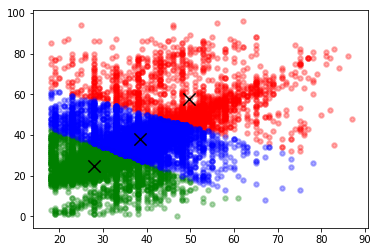

0.3999465029185761


In [4]:
import ssl
from sklearn import metrics
from numpy.random import seed
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy import isnan, nan, take, where

seed(42)
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context
    
keep = ['edad_a', 'edad_v'] # dos atributos numéricos para comenzar (edades de agresor y victima)
d = d.loc[:, keep]
x = d.values
k = 3 # pedimos tres grupos
m = KMeans(init = 'random', n_clusters = k, n_init = 10)
m.fit(x)
centroides = m.cluster_centers_
grupos = m.predict(x)
plt.figure(1)
plt.scatter(centroides[:, 0], centroides[:, 1], marker='x', s=150, linewidths=3, color='black', zorder=10)
colores = ['r', 'g', 'b']
for g in range(k):
    incl = where(grupos == g)[0]
    print(len(incl), "integrantes en grupo", g)
    grupo = take(x, incl, 0)
    plt.scatter(grupo[:, 0], grupo[:, 1], marker='o', s=20, linewidths=2, color=colores[g], alpha = 0.3, zorder=5)
plt.show()
print(metrics.silhouette_score(x, grupos, metric='euclidean'))


Ahora, se prueba con diferentes valores de k para ver cuál da el mejor valor del coeficiente de silueta.

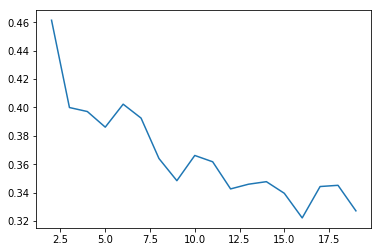

In [5]:
x = d.values
ks = [k for k in range(2, 20)]
sil = []
for k in ks:
    m = KMeans(init = 'random', n_clusters = k, n_init = 10)
    m.fit(x)
    sil.append(metrics.silhouette_score(x, m.predict(x), metric='euclidean'))
plt.figure(1)
plt.plot(ks, sil)
plt.show()

El mejor coeficiente de silueta se encuentra para k=2. 

Nuevamente, se usa el algoritmo pero ahora se utilizan más atributos: sexo del agresor y la víctima, mes y hora del incidente. Para poder tener una visualización bidimensional se aplica primero un análisis de componentes principales.

1    13135
0      496
Name: etiquetas, dtype: int64
6360 integrantes en grupo 0


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2344 integrantes en grupo 1
4927 integrantes en grupo 2


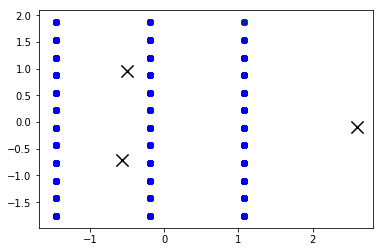

0.21821034737366488


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

datos = pd.read_csv("vf_p11.csv")
d = {'sa': datos.sexo_a, 'sv': datos.sexo_v, 'edad_v': datos.edad_v, 'mes': datos.mes, 'hr': datos.hora, 'edad_a': datos.edad_a}
d = pd.DataFrame(data = d)

pri = d.edad_v >= 18
d['etiquetas'] = [1 if  pri[i] else 0 for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['hr', 'mes', 'sa', 'sv', 'edad_a']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)

k = 3 # pedimos tres grupos
m = KMeans(init = 'random', n_clusters = k, n_init = 10)
m.fit(X)
centroides = m.cluster_centers_
grupos = m.predict(X)
plt.figure(1)
plt.scatter(centroides[:, 0], centroides[:, 1], marker='x', s=150, linewidths=3, color='black', zorder=10)
colores = ['r', 'g', 'b']
for g in range(k):
    incl = where(grupos == g)[0]
    print(len(incl), "integrantes en grupo", g)
    grupo = take(x, incl, 0)
    plt.scatter(grupo[:, 0], grupo[:, 1], marker='o', s=20, linewidths=2, color=colores[g], alpha = 0.3, zorder=5)
plt.show()
print(metrics.silhouette_score(x, grupos, metric='euclidean'))

### MeanShift

El agrupamiento de [MeanShift](https://scikit-learn.org/stable/modules/clustering.html#mean-shift) es un algoritmo basado en centroides, que funciona mediante la actualización de candidatos a centroides de forma que éstos sean la media de los puntos dentro de una región determinada. Estos candidatos luego se filtran en una etapa de post-procesamiento para eliminar los duplicados cercanos y formar el conjunto final de centroides.



[[31.7765685  30.03729193]
 [41.65238095 71.23809524]]


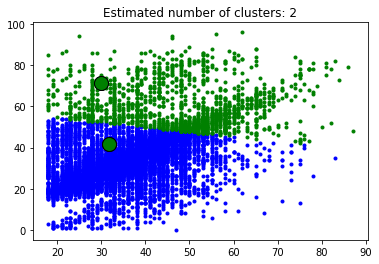

In [7]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

datos = pd.read_csv("vf_p11.csv")
keep = ['edad_a', 'edad_v'] # dos atributos numéricos para comenzar (edades de agresor y victima)
datos = datos.loc[:, keep]
x = datos.values
bandwidth = estimate_bandwidth(x, quantile=0.2)
m = MeanShift(bandwidth = bandwidth)
m.fit(x)
labels = m.labels_
centroide = m.cluster_centers_
print(centroide)

labels_unique = np.unique(labels)
nc = len(labels_unique)

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(nc), colors):
    my_members = labels == k
    cluster_center = centroide[k]
    plt.plot(x[my_members, 0], x[my_members, 1], col + '.')
    plt.plot(centroide[0], centroide[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % nc)
plt.show()